## Model One


Two bacterial populations, sensitive and resistant wit seperate EC_50 for each antibitoic.\
No antibiotic period = 48 hours.  This is the time period when both sensitive and resistant bacteria grow unopposed.\
Vancomycin initial treatment duration = 72 hours at which point it is discontinued and Linezolid statred.\
Linezolid continue for 96 hours.  Total sim time = 250 hours\
Vancomycin dosing 500 mg q 12 hours\
Linezolid dosing 800 mg q 8 hours


Linezolid is bacteriostatic\
Vancomycin is bacteriostatic or bactericidal

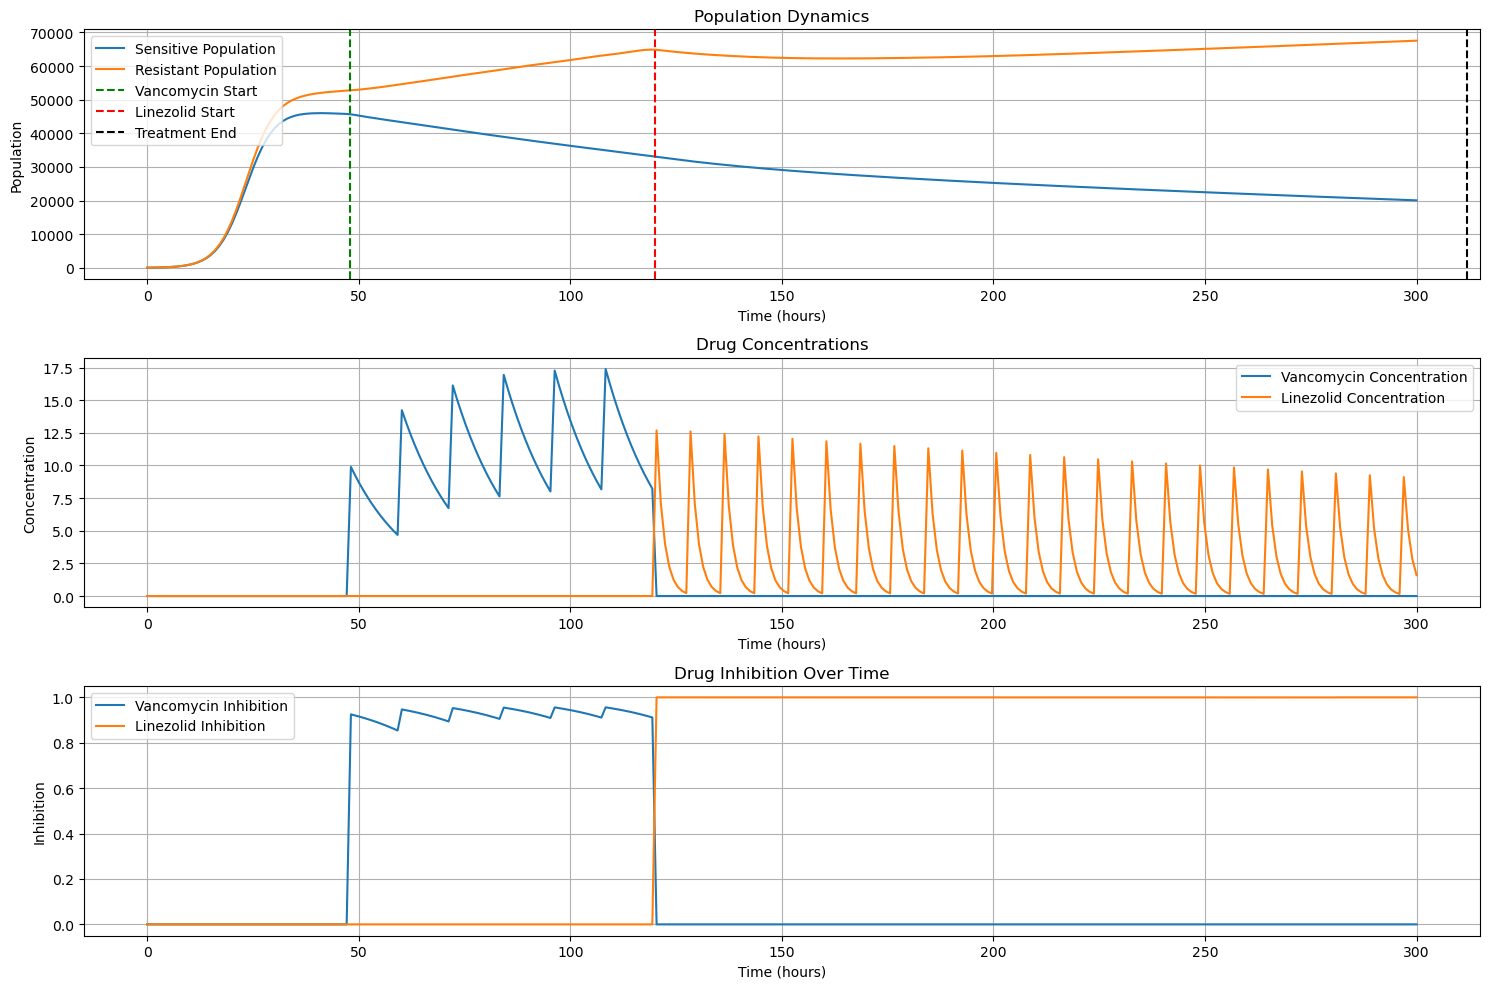

In [165]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the elimination rates for each antibiotic
def Ke_Vancomycin(sCr, Age, weight, V=49):
    eCCr = (140 - Age) * weight / (72 * sCr)
    Vanco_CL = (60 * eCCr) / (1000 * 1.08)  # l/hr
    return Vanco_CL / V  # hr^-1

def Ke_Linezolid(sCr, Age, weight, V=50):
    CrCL = (140 - Age) * weight / (72 * sCr)
    CL_linezolid = 5 + (CrCL * 0.4)
    return CL_linezolid / V

# Define the concentration of antibiotics in the blood
def concentration(t, D, V, Ke, tau, start_time, end_time):
    conc = np.zeros_like(t)
    dosing_times = np.arange(start_time, end_time, tau)
    for i, time_point in enumerate(t):
        if start_time <= time_point <= end_time:
            for dose_time in dosing_times:
                if time_point >= dose_time:
                    conc[i] += (D / V) * np.exp(-Ke * (time_point - dose_time))
    return conc

# Simulate the drug dynamics and bacterial population
def simulate_drug_dynamics(
    EC_50_vanco,
    EC_50_linez,
    initial_sensitive=50,
    initial_resistant=50,
    no_drug_period=48,
    vancomycin_duration=72,
    linezolid_duration=192,
    total_simulation_time=300,
):
    # Timing
    vanco_start = no_drug_period
    vanco_end = vanco_start + vancomycin_duration
    linez_start = vanco_end
    linez_end = linez_start + linezolid_duration

    # Patient Parameters
    sCr = 1.3
    Age = 60
    weight = 70
    V_vanco = 50
    V_linezolid = 50
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight)
    Ke_linez = Ke_Linezolid(sCr, Age, weight)

    # Time Array
    time = np.linspace(0, total_simulation_time, total_simulation_time)

    # Drug Dosing
    D_vancomycin, tau_vancomycin = 500, 12
    D_linezolid, tau_linezolid = 800, 8

    # Drug Concentrations
    conc_vancomycin = concentration(time, D_vancomycin, V_vanco, Ke_vanco, tau_vancomycin, vanco_start, vanco_end)
    conc_linezolid = concentration(time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid, linez_start, linez_end)
    
    # Population Dynamics Parameters
    rho_sensitive, rho_resistant = 0.3, 0.3
    delta_sensitive, delta_resistant = 0.006, 0.003
    max_drug_effect_vanco, max_drug_effect_linez = 0.8, 0.9
    k = 1e5

    def population_ode(t, r):
        S, R = r
        if t <= no_drug_period:
            # No drug inhibition during no-drug period
            total_inhibition_sensitive = 0
            total_inhibition_resistant = 0
        else:
            # Drug inhibition starts after the no-drug period
            conc_vanco_t = np.interp(t, time, conc_vancomycin)
            conc_linez_t = np.interp(t, time, conc_linezolid)

            vanco_effect = max_drug_effect_vanco * (conc_vanco_t / (conc_vanco_t + EC_50_vanco))
            linez_effect_sensitive = max_drug_effect_linez * (conc_linez_t / (conc_linez_t + EC_50_linez))
            linez_effect_resistant = max_drug_effect_linez * (conc_linez_t / (conc_linez_t + EC_50_linez))

            total_inhibition_sensitive = vanco_effect + linez_effect_sensitive
            total_inhibition_resistant = linez_effect_resistant

        # Logistic growth with drug inhibition
        dSdt = rho_sensitive * S * (1 - (S + R) / k) * (1 - total_inhibition_sensitive) - delta_sensitive * S
        dRdt = rho_resistant * R * (1 - (S + R) / k) * (1 - total_inhibition_resistant) - delta_resistant * R
        return [dSdt, dRdt]

    # Solve ODE
    solution = solve_ivp(
        population_ode,
        [0, total_simulation_time],
        [initial_sensitive, initial_resistant],
        t_eval=time,
        method='RK45',
    )
    #print(solution.y[0])
    #print(solution.y[1])
    #print(solution.t)
    # Plot Results
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(time, solution.y[0], label='Sensitive Population')
    plt.plot(time, solution.y[1], label='Resistant Population')
    plt.axvline(vanco_start, color='g', linestyle='--', label='Vancomycin Start')
    plt.axvline(linez_start, color='r', linestyle='--', label='Linezolid Start')
    plt.axvline(linez_end, color='k', linestyle='--', label='Treatment End')
    plt.title('Population Dynamics')
    plt.xlabel('Time (hours)')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(time, conc_vancomycin, label='Vancomycin Concentration')
    plt.plot(time, conc_linezolid, label='Linezolid Concentration')
    plt.title('Drug Concentrations')
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(time, conc_vancomycin / (conc_vancomycin + EC_50_vanco), label='Vancomycin Inhibition')
    plt.plot(time, conc_linezolid / (conc_linezolid + EC_50_linez), label='Linezolid Inhibition')
    plt.title('Drug Inhibition Over Time')
    plt.xlabel('Time (hours)')
    plt.ylabel('Inhibition')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run the simulation
simulate_drug_dynamics(EC_50_vanco=0.8, EC_50_linez=0.00005)


## Changes made to prior model

Fitness cost of developing antibiotic resistance added to the model.  Growth of resistant bacteria written in term of sensitive bacteria and a fitness cost of 20%.  

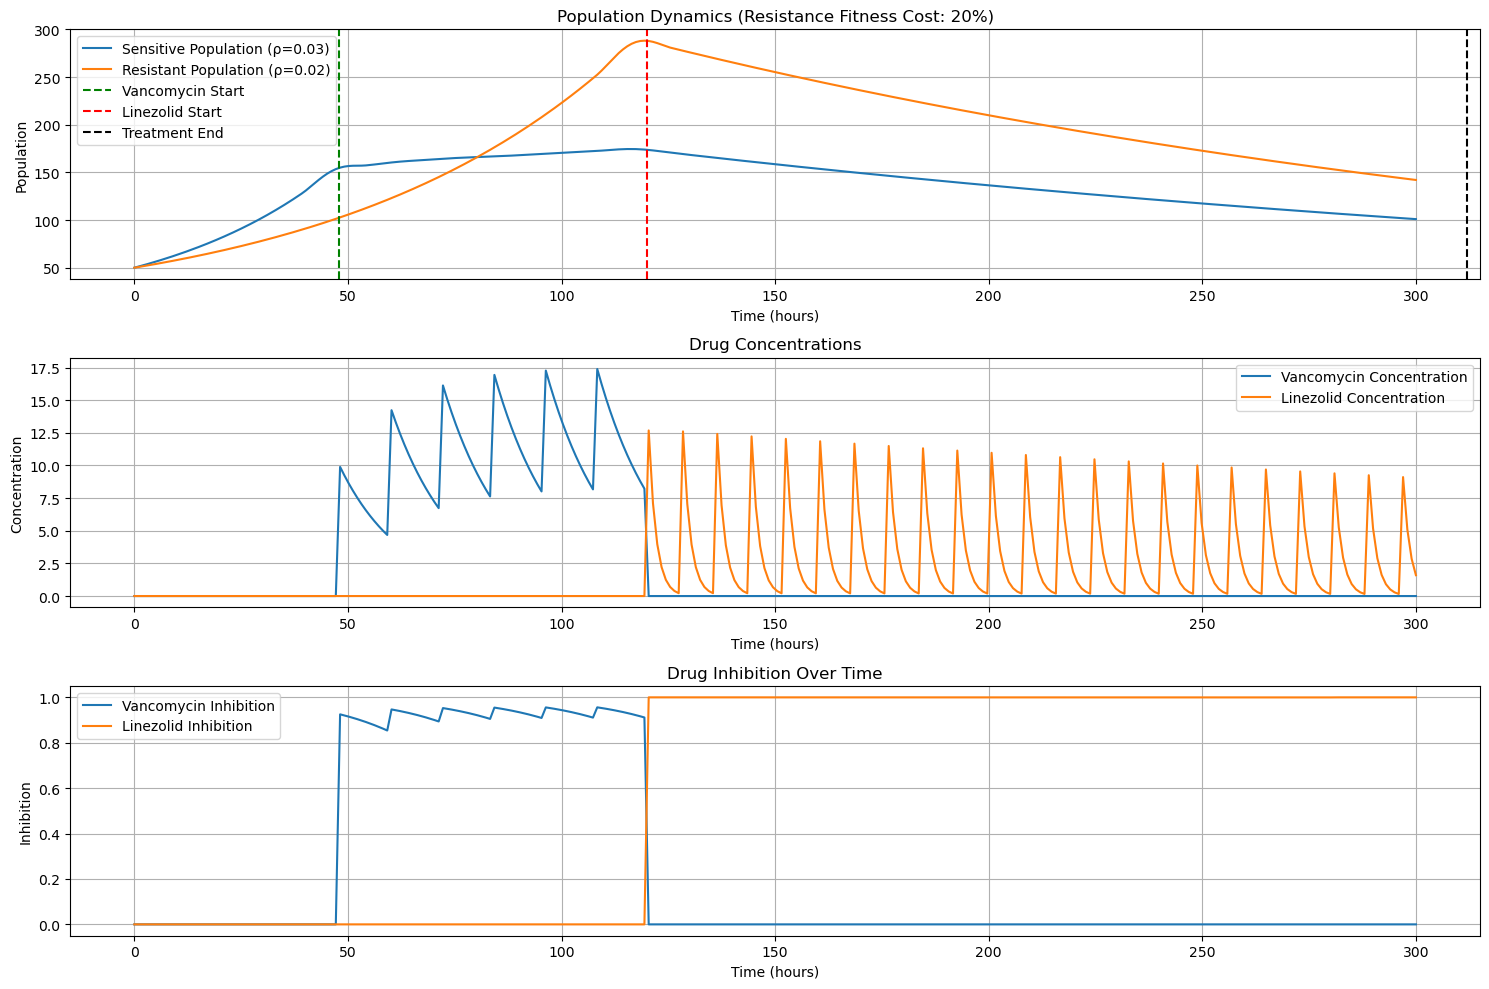

In [169]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the elimination rates for each antibiotic
def Ke_Vancomycin(sCr, Age, weight, V=49):
    eCCr = (140 - Age) * weight / (72 * sCr)
    Vanco_CL = (60 * eCCr) / (1000 * 1.08)  # l/hr
    return Vanco_CL / V  # hr^-1

def Ke_Linezolid(sCr, Age, weight, V=50):
    CrCL = (140 - Age) * weight / (72 * sCr)
    CL_linezolid = 5 + (CrCL * 0.4)
    return CL_linezolid / V

# Define the concentration of antibiotics in the blood
def concentration(t, D, V, Ke, tau, start_time, end_time):
    conc = np.zeros_like(t)
    dosing_times = np.arange(start_time, end_time, tau)
    for i, time_point in enumerate(t):
        if start_time <= time_point <= end_time:
            for dose_time in dosing_times:
                if time_point >= dose_time:
                    conc[i] += (D / V) * np.exp(-Ke * (time_point - dose_time))
    return conc

# Simulate the drug dynamics and bacterial population
def simulate_drug_dynamics(
    EC_50_vanco,
    EC_50_linez,
    fitness_cost=0.2,  # Added fitness cost parameter
    initial_sensitive=50,
    initial_resistant=50,
    no_drug_period=48,
    vancomycin_duration=72,
    linezolid_duration=192,
    total_simulation_time=300,
):
    # Timing
    vanco_start = no_drug_period
    vanco_end = vanco_start + vancomycin_duration
    linez_start = vanco_end
    linez_end = linez_start + linezolid_duration

    # Patient Parameters
    sCr = 1.3
    Age = 60
    weight = 70
    V_vanco = 50
    V_linezolid = 50
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight)
    Ke_linez = Ke_Linezolid(sCr, Age, weight)

    # Time Array
    time = np.linspace(0, total_simulation_time, total_simulation_time)

    # Drug Dosing
    D_vancomycin, tau_vancomycin = 500, 12
    D_linezolid, tau_linezolid = 800, 8

    # Drug Concentrations
    conc_vancomycin = concentration(time, D_vancomycin, V_vanco, Ke_vanco, tau_vancomycin, vanco_start, vanco_end)
    conc_linezolid = concentration(time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid, linez_start, linez_end)
    
    # Population Dynamics Parameters
    rho_sensitive = 0.03
    rho_resistant = rho_sensitive * (1 - fitness_cost)  # Apply fitness cost to resistant strain's growth rate
    delta_sensitive, delta_resistant = 0.006, 0.006
    max_drug_effect_vanco, max_drug_effect_linez = 0.8, 0.9
    k = 1e5

    def population_ode(t, r):
        S, R = r
        if t <= no_drug_period:
            # No drug inhibition during no-drug period
            total_inhibition_sensitive = 0
            total_inhibition_resistant = 0
        else:
            # Drug inhibition starts after the no-drug period
            conc_vanco_t = np.interp(t, time, conc_vancomycin)
            conc_linez_t = np.interp(t, time, conc_linezolid)

            vanco_effect = max_drug_effect_vanco * (conc_vanco_t / (conc_vanco_t + EC_50_vanco))
            linez_effect_sensitive = max_drug_effect_linez * (conc_linez_t / (conc_linez_t + EC_50_linez))
            linez_effect_resistant = max_drug_effect_linez * (conc_linez_t / (conc_linez_t + EC_50_linez))

            total_inhibition_sensitive = vanco_effect + linez_effect_sensitive
            total_inhibition_resistant = linez_effect_resistant

        # Logistic growth with drug inhibition
        dSdt = rho_sensitive * S * (1 - (S + R) / k) * (1 - total_inhibition_sensitive) - delta_sensitive * S
        dRdt = rho_resistant * R * (1 - (S + R) / k) * (1 - total_inhibition_resistant) - delta_resistant * R
        return [dSdt, dRdt]

    # Solve ODE
    solution = solve_ivp(
        population_ode,
        [0, total_simulation_time],
        [initial_sensitive, initial_resistant],
        t_eval=time,
        method='RK45',
    )

    # Plot Results
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(time, solution.y[0], label=f'Sensitive Population (ρ={rho_sensitive:.2f})')
    plt.plot(time, solution.y[1], label=f'Resistant Population (ρ={rho_resistant:.2f})')
    plt.axvline(vanco_start, color='g', linestyle='--', label='Vancomycin Start')
    plt.axvline(linez_start, color='r', linestyle='--', label='Linezolid Start')
    plt.axvline(linez_end, color='k', linestyle='--', label='Treatment End')
    plt.title(f'Population Dynamics (Resistance Fitness Cost: {20}%)')
    plt.xlabel('Time (hours)')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(time, conc_vancomycin, label='Vancomycin Concentration')
    plt.plot(time, conc_linezolid, label='Linezolid Concentration')
    plt.title('Drug Concentrations')
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(time, conc_vancomycin / (conc_vancomycin + EC_50_vanco), label='Vancomycin Inhibition')
    plt.plot(time, conc_linezolid / (conc_linezolid + EC_50_linez), label='Linezolid Inhibition')
    plt.title('Drug Inhibition Over Time')
    plt.xlabel('Time (hours)')
    plt.ylabel('Inhibition')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run the simulation
simulate_drug_dynamics(EC_50_vanco=0.8, EC_50_linez=0.00005, fitness_cost=0.3)